<a href="https://colab.research.google.com/github/kazukiminemura/dcgan_colab/blob/main/cdgan_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf /content/datasets/.git
!rm /content/datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 27.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
# data augmentation
train_aug_dir = 'datasets'

import os
import cv2
import sys
import glob
import numpy as np

In [5]:
def equalizeHistRGB(src):
  RGB = cv2.split(src)
  Blue = RGB[0]
  Green = RGB[1]
  Red = RGB[2]
  for i in range(3):
    cv2.equalizeHist(RGB[i])
  img_hist = cv2.merge([RGB[0], RGB[1], RGB[2]])
  return img_hist

def addGaussianNoise(src):
  row, col, ch = src.shape
  mean = 0
  var = 0.1
  sigma = 15
  gauss = np.random.normal(mean, sigma, (row, col, ch))
  gauss = gauss.reshape(row, col, ch)
  noisy = src + gauss
  return noisy

def addSaltPepperNoise(src):
  s_vs_p = 0.5
  amount = 0.004
  out = src.copy()

  # Salt mode
  num_salt = np.ceil(amount * src.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in src.shape]
  out[coords[: -1]] = (255, 255, 255)

  # Pepper mode
  num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1 , int(num_pepper))
            for i in src.shape]
  out[coords[: -1]] = (0, 0, 0)
  
  return out

In [8]:
labels = os.listdir(train_aug_dir)
print(labels)
image_file_names= []
for label in labels:
  image_files = glob.glob(train_aug_dir + '/' + label + '/*')
  for image_file in image_files:
    image_file_names.append(image_file)

print(image_file_names)

['pa', 'choki', 'gu']
['datasets/pa/IMG_0833.JPG', 'datasets/pa/IMG_0827.JPG', 'datasets/pa/IMG_0850.JPG', 'datasets/pa/IMG_0840.JPG', 'datasets/pa/IMG_0845.JPG', 'datasets/pa/IMG_0865.JPG', 'datasets/pa/IMG_0862.JPG', 'datasets/pa/IMG_0838.JPG', 'datasets/pa/IMG_0868.JPG', 'datasets/pa/IMG_0834.JPG', 'datasets/pa/IMG_0837.JPG', 'datasets/pa/IMG_0858.JPG', 'datasets/pa/IMG_0823.JPG', 'datasets/pa/IMG_0849.JPG', 'datasets/pa/IMG_0846.JPG', 'datasets/pa/IMG_0852.JPG', 'datasets/pa/IMG_0830.JPG', 'datasets/pa/IMG_0826.JPG', 'datasets/pa/IMG_0856.JPG', 'datasets/pa/IMG_0828.JPG', 'datasets/pa/IMG_0822.JPG', 'datasets/pa/IMG_0819.JPG', 'datasets/pa/IMG_0829.JPG', 'datasets/pa/IMG_0861.JPG', 'datasets/pa/IMG_0854.JPG', 'datasets/pa/IMG_0832.JPG', 'datasets/pa/IMG_0841.JPG', 'datasets/pa/IMG_0869.JPG', 'datasets/pa/IMG_0835.JPG', 'datasets/pa/IMG_0836.JPG', 'datasets/pa/IMG_0848.JPG', 'datasets/pa/IMG_0831.JPG', 'datasets/pa/IMG_0825.JPG', 'datasets/pa/IMG_0863.JPG', 'datasets/pa/IMG_0824.JPG

In [22]:
# lookup table
min_table = 50
max_table = 205
diff_table = max_table - min_table
gamma1 = 0.75
gamma2 = 1.5

LUT_HC = np.arange(256, dtype=np.uint8)
LUT_LC = np.arange(256, dtype=np.uint8)
LUT_G1 = np.arange(256, dtype=np.uint8)
LUT_G2 = np.arange(256, dtype=np.uint8)
LUTs = []

# smoothing
average_square = (10, 10)

# high contrast LUT
for i in range(0, min_table):
  LUT_HC[i] = 0
for i in range(min_table, max_table):
  LUT_HC[i] = 255 * (i - min_table) / diff_table
for i in range(max_table, 255):
  LUT_HC[i] = 255

# other LUT
for i in range(256):
  LUT_LC[i] = min_table + i * (diff_table) / 255
  LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
  LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

LUTs.append(LUT_HC)
LUTs.append(LUT_LC)
LUTs.append(LUT_G1)
LUTs.append(LUT_G2)

for image_file in image_file_names:
  img_src = cv2.imread(image_file, 1)
  trans_img = []
  trans_img.append(img_src)

  # teansfer LUT
  for i, LUT in enumerate(LUTs):
    trans_img.append(cv2.LUT(img_src, LUT))
  # print(len(trans_img))

  # smoothing
  trans_img.append(cv2.blur(img_src, average_square))
  # equalization
  trans_img.append(equalizeHistRGB(img_src))
  # adding noise
  trans_img.append(addGaussianNoise(img_src))
  trans_img.append(addSaltPepperNoise(img_src))
  # flip
  flip_img = []
  for img in trans_img:
    flip_img.append(cv2.flip(img, 1))
  trans_img.extend(flip_img)

  dir_name = os.path.splitext(os.path.dirname(image_file))[0]
  base_name = os.path.splitext(os.path.basename(image_file))[0]
  img_src.astype(np.float64)

  for i, img in enumerate(trans_img):
    if i > 0:
      # print(f'{dir_name}/trans_{base_name}_{str(i - 1)}.jpg')

      cv2.imwrite(f'{dir_name}/trans_{base_name}_{str(i - 1)}.jpg', img)


5
5
5
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [21]:
!ls datasets/choki

choki_01.jpg	       trans_IMG_0788_16.jpg  trans_IMG_0811_5.jpg
IMG_0770.JPG	       trans_IMG_0788_1.jpg   trans_IMG_0811_6.jpg
IMG_0771.JPG	       trans_IMG_0788_2.jpg   trans_IMG_0811_7.jpg
IMG_0772.JPG	       trans_IMG_0788_3.jpg   trans_IMG_0811_8.jpg
IMG_0773.JPG	       trans_IMG_0788_4.jpg   trans_IMG_0811_9.jpg
IMG_0774.JPG	       trans_IMG_0788_5.jpg   trans_IMG_0812_0.jpg
IMG_0775.JPG	       trans_IMG_0788_6.jpg   trans_IMG_0812_10.jpg
IMG_0776.JPG	       trans_IMG_0788_7.jpg   trans_IMG_0812_11.jpg
IMG_0777.JPG	       trans_IMG_0788_8.jpg   trans_IMG_0812_12.jpg
IMG_0778.JPG	       trans_IMG_0788_9.jpg   trans_IMG_0812_13.jpg
IMG_0779.JPG	       trans_IMG_0789_0.jpg   trans_IMG_0812_14.jpg
IMG_0780.JPG	       trans_IMG_0789_10.jpg  trans_IMG_0812_15.jpg
IMG_0781.JPG	       trans_IMG_0789_11.jpg  trans_IMG_0812_16.jpg
IMG_0782.JPG	       trans_IMG_0789_12.jpg  trans_IMG_0812_1.jpg
IMG_0783.JPG	       trans_IMG_0789_13.jpg  trans_IMG_0812_2.jpg
IMG_0784.JPG	       trans_IMG_078

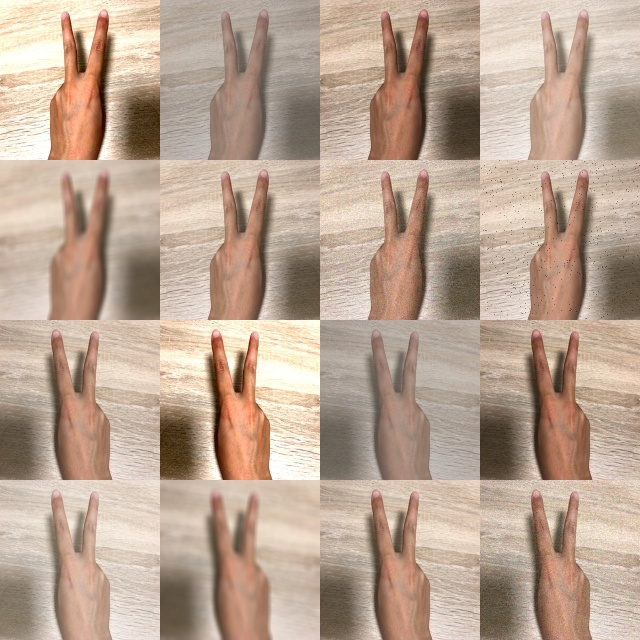

In [25]:
# show generated images
from IPython.display import Image as IPImage
from IPython.display import display_jpeg

tmp_file_name = './datasets/choki/trans_choki_01'

tmp_image = []
for i in range(16):
  tmp_image.append(cv2.imread(f'{tmp_file_name}_{str(i)}.jpg'))

tmp_hconcat_image = []
tmp_hconcat_image.append(cv2.hconcat(tmp_image[0: 4]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[4: 8]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[8: 12]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[12: 16]))

concat_image = cv2.vconcat(tmp_hconcat_image[0: 4])
concat_image = cv2.resize(concat_image, dsize=(640, 640))
cv2.imwrite('concat.jpg', concat_image)

display_jpeg(IPImage('concat.jpg'))

In [27]:
# DCGAN model
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.8.0


In [74]:
import os
import csv
import time
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.layers.core import Flatten, Activation
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU


In [30]:
# minbatch
def image_batch(batch_size: int):
  files = glob.glob('./datasets/*/*')
  files = random.sample(files, batch_size)
  res = []
  for path in files:
    img = Image.open(path)
    img = img.resize((64, 64))
    arr = np.array(img)
    arr = (arr - 127.5) / 127.5
    arr.resize((64, 64, 3))
    res.append(arr)
  return np.array(res)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


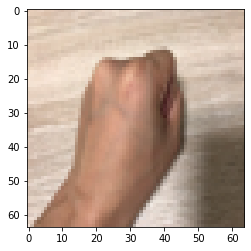

In [36]:
test_image = image_batch(25)
plt.imshow(test_image[0])
plt.imshow((test_image[0] + 1)/2)

In [42]:
def combine_images(generated_images, cols=5, rows=5):
  shape = generated_images.shape
  h = shape[1]
  w = shape[2]
  image = np.zeros((rows * h, cols * w, 3))
  for index, img in enumerate(generated_images):
    if index >= cols * rows:
      break
    i = index // cols
    j = index % cols
    image[i * h: (i + 1) * h, j * w: (j + 1) * w, :] = img[:, :, :]
  
  image = image * 127.5 + 127.5
  image = Image.fromarray(image.astype(np.uint8))
  return image

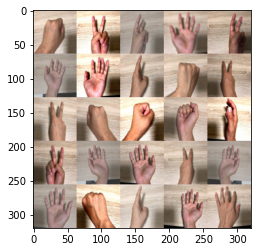

In [43]:
test_combined_image = combine_images(test_image)
plt.imshow(test_combined_image)

In [44]:
# create DCGAN model
BATCH_SIZE = 32
EPHOCHS = 1001

model_dir = './model'
gen_images_dir = './gen_images'
each_step = 50

In [60]:
# GAN topology
def generator_model():
  model = Sequential()
  model.add(Dense(1024, input_shape=(100,)))
  model.add(Activation('tanh'))
  model.add(Dense(128 * 16 * 16))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))
  model.add(Reshape((16, 16, 128)))
  model.add(UpSampling2D(size=(2, 2)))
  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(Activation('tanh'))
  model.add(UpSampling2D(size=(2, 2)))
  model.add(Conv2D(3, (5, 5), padding='same'))
  model.add(Activation('tanh'))
  
  return model

def discriminator_model():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), input_shape=(64, 64, 3), padding='same'))
  model.add(Activation('tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (5, 5)))
  model.add(Activation('tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('tanh'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def generator_containing_discriminator(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  return model

In [75]:
# create Instances
def set_trainable(model, trainable):
  model.trainable = trainable
  for layer in model.layers:
    layer.trainable = trainable

discriminator = discriminator_model()
generator = generator_model()
discriminator_on_generator = generator_containing_discriminator(
    generator, discriminator)

set_trainable(discriminator, True)
discriminator.compile(
    loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=2e-4, beta_1=0.5))

set_trainable(discriminator, False)
discriminator_on_generator.compile(
    loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=2e-4, beta_1=0.5))

print(generator.summary())
print(discriminator.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 1024)              103424    
                                                                 
 activation_57 (Activation)  (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 32768)             33587200  
                                                                 
 batch_normalization_5 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 activation_58 (Activation)  (None, 32768)             0         
                                                                 
 reshape_5 (Reshape)         (None, 16, 16, 128)       0         
                                                     

In [76]:
# train GAN
if not os.path.isdir(gen_images_dir):
  os.mkdir(gen_images_dir)

# graph data
csvlist = []
csvlist.append([])
csvlist[0].append('step')
csvlist[0].append('g_loss')
csvlist[0].append('d_loss')

for i in tqdm(range(EPOCHS)):
  batch_images = image_batch(BATCH_SIZE)

  noise = np.random.uniform(
      size=[BATCH_SIZE, 100], low=-1.0, high=1.0)
  generated_images = generator.predict(noise)
  X = np.concatenate(batch_images, generated_images)
  y = [1]* BATCH_SIZE + [0] * BATCH_SIZE
  d_loss = discriminator.train_on_batch(X, y)

  noise = np.random.uniform(
      size=[BATCH_SIZE, 100], low=-1.0, high=1.0)
  g_loss = discriminator_on_generator.train_on_batch(
      noise, [1] * BATCH_SIZE)
  
  # add graph data
  csvlist.append([])
  csvlist[i + 1].append(i)
  csvlist[i + 1].append(g_loss)
  csvlist[i + 1].append(d_loss)

  if i % each_step == 0:
    # show image
    image = combine_images(generated_images)
    plt.ion()
    plt.imshow(image)
    plt.pause(0.001)
    # save image
    image.save(gen_images_dir + '/gen%05d.png' % i)

# saev graph data csv
with open('./train_graph.csv', 'w') as f:
  dataWriter = csv.writer(f)
  dataWriter.writerows(csvlist)